# Feature Analysis for Bitcoin Fraud Detection

Both Logistic Regression and GCN perform very poorly (F1 ~ 0.07-0.08).
This notebook investigates the **quality and usefulness of node features**.

## Questions to Answer:
1. **Feature Quality**: Do features have predictive power?
2. **Feature Distribution**: Are features normalized? Any outliers?
3. **Class Separation**: Can we distinguish illicit vs licit nodes?
4. **Feature Importance**: Which features matter most?
5. **Correlation**: Are features redundant or complementary?
6. **Temporal Issues**: Do features change drastically over time?

## Setup

In [1]:
import sys
from pathlib import Path

# Add parent directory to path
ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder,
    load_elliptic_data
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mutual_info_score
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

In [ ]:
CONFIG = {
    'data_dir': '../elliptic_dataset',
    'train_timesteps': (5, 24), # for t 24 and k = 5 we use graphs at t = 24, 25, 26, 27, 28
    'val_timesteps': (29, 31), # for t 31 and k = 5 we use graphs at t = 31, 32, 33, 34, 35
    'test_timesteps': (37, 43), # for t 43 and k = 5 we use graphs at t = 43, 44, 45, 46, 47
    'observation_windows': [0, 3, 5],
    'seed': 42
}

np.random.seed(CONFIG['seed'])

## 1. Load Data

In [3]:
print("Loading Elliptic Bitcoin dataset...")
nodes_df, edges_df = load_elliptic_data(CONFIG['data_dir'], use_temporal_features=True)

print(f"\nNodes: {nodes_df.shape}")
print(f"Edges: {edges_df.shape}")
print(f"Unique addresses: {nodes_df['address'].nunique():,}")

print(f"\nColumns: {list(nodes_df.columns)}")

Loading Elliptic Bitcoin dataset...

Nodes: (920691, 119)
Edges: (2868964, 187)
Unique addresses: 822,942

Columns: ['address', 'Time step', 'in_num', 'in_total_fees', 'in_mean_fees', 'in_median_fees', 'in_total_btc_in', 'in_mean_btc_in', 'in_median_btc_in', 'in_fees_sum', 'in_fees_mean', 'in_fees_median', 'in_size_sum', 'in_size_mean', 'in_size_median', 'in_in_txs_degree_sum', 'in_in_txs_degree_mean', 'in_in_txs_degree_median', 'in_out_txs_degree_sum', 'in_out_txs_degree_mean', 'in_out_txs_degree_median', 'in_num_input_addresses_sum', 'in_num_input_addresses_mean', 'in_num_input_addresses_median', 'in_num_output_addresses_sum', 'in_num_output_addresses_mean', 'in_num_output_addresses_median', 'in_total_BTC_sum', 'in_total_BTC_mean', 'in_total_BTC_median', 'in_in_BTC_min_sum', 'in_in_BTC_min_mean', 'in_in_BTC_min_median', 'in_in_BTC_max_sum', 'in_in_BTC_max_mean', 'in_in_BTC_max_median', 'in_in_BTC_mean_sum', 'in_in_BTC_mean_mean', 'in_in_BTC_mean_median', 'in_in_BTC_median_sum', 'in_i

In [14]:
builder = TemporalNodeClassificationBuilder(
    nodes_df=nodes_df,
    edges_df=edges_df,
    include_class_as_feature=False,
    add_temporal_features=True,
    verbose=True,
    cache_dir=ROOT / 'graph_cache'
)

  Pre-processing node features by (address, timestep)...
  Pre-processing edges by timestep...
  Average new nodes per timestep: 16794.7
Initialized TemporalNodeClassificationBuilder
  Total nodes: 822942
  Total edges: 2868964
  Time steps: 1 to 49
  Feature columns (116): ['in_num', 'in_total_fees', 'in_mean_fees', 'in_median_fees', 'in_total_btc_in']...
  Include class as feature: False
  Add temporal features: True
  Add edge weights: False


In [45]:
split = builder.get_train_val_test_split(
    train_timesteps=CONFIG['train_timesteps'],
    val_timesteps=CONFIG['val_timesteps'],
    test_timesteps=CONFIG['test_timesteps'],
    filter_unknown=True
)

train_nodes = split['train']
val_nodes = split['val']
test_nodes = split['test']

total_nodes = len(train_nodes) + len(val_nodes) + len(test_nodes)
print(f"\nSplit:")
print(f"  Train: {len(train_nodes):,} nodes. {len(train_nodes) / total_nodes:.2%} of total.")
print(f"  Val:   {len(val_nodes):,} nodes. {len(val_nodes) / total_nodes:.2%} of total.")
print(f"  Test:  {len(test_nodes):,} nodes. {len(test_nodes) / total_nodes:.2%} of total.")


Temporal Split Summary:
  Train: timesteps 5-24, 96470 nodes
    Illicit: 4888, Licit: 91582
Training illicit ratio: 0.050668601637814864
  Val:   timesteps 29-31, 9884 nodes
    Illicit: 664, Licit: 9220
Validation illicit ratio: 0.06717927964386888
  Test:  timesteps 37-43, 39305 nodes
    Illicit: 1849, Licit: 37456
Test illicit ratio: 0.04704236102277064

Split:
  Train: 96,470 nodes. 66.23% of total.
  Val:   9,884 nodes. 6.79% of total.
  Test:  39,305 nodes. 26.98% of total.


## 2. Extract Features and Labels

Build graph at K=0 to get features for all nodes.

In [25]:
print("Building graph at t=45...")
graph = builder.build_graph_at_timestep(45, return_node_metadata=True)

print(f"\nGraph:")
print(f"  Nodes: {graph.num_nodes:,}")
print(f"  Edges: {graph.edge_index.shape[1]:,}")
print(f"  Features: {graph.x.shape[1]}")

Building graph at t=45...
  ⚠️  Failed to load cached graph: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch_geometric.data.data.DataEdgeAttr was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch_geometric.data.data.DataEdgeAttr])` or the `torch.serialization.safe_globals([torch_geometric.data.data.DataEdgeAttr])` context manager to allowlist this global if you trust this c

In [26]:
addr_to_idx = {addr: idx for idx, addr in enumerate(graph.node_address)}

def get_features_labels(nodes_df, graph, addr_to_idx):
    indices = [addr_to_idx[addr] for addr in nodes_df['address'] if addr in addr_to_idx]
    X = graph.x[indices].numpy()
    y = 2 - graph.y[indices].numpy()
    return X, y, indices

X_train, y_train, train_indices = get_features_labels(train_nodes, graph, addr_to_idx)
X_val, y_val, val_indices = get_features_labels(val_nodes, graph, addr_to_idx)
X_test, y_test, test_indices = get_features_labels(test_nodes, graph, addr_to_idx)

print(f"\nExtracted features:")
print(f"  Train: {X_train.shape}, licit={np.sum(y_train==0)}, illicit={np.sum(y_train==1)}")
print(f"  Val:   {X_val.shape}, licit={np.sum(y_val==0)}, illicit={np.sum(y_val==1)}")
print(f"  Test:  {X_test.shape}, licit={np.sum(y_test==0)}, illicit={np.sum(y_test==1)}")


Extracted features:
  Train: (109133, 117), licit=101896, illicit=7237
  Val:   (16718, 117), licit=15413, illicit=1305
  Test:  (50876, 117), licit=47658, illicit=3218


## 3. Basic Feature Statistics

In [27]:
print("="*70)
print("FEATURE STATISTICS (Training Set)")
print("="*70)

feature_names = [f"F{i}" for i in range(X_train.shape[1])]

# Basic stats
stats = pd.DataFrame({
    'Feature': feature_names,
    'Mean': X_train.mean(axis=0),
    'Std': X_train.std(axis=0),
    'Min': X_train.min(axis=0),
    'Max': X_train.max(axis=0),
    'Median': np.median(X_train, axis=0),
    'Zero%': (X_train == 0).mean(axis=0) * 100
})

# Identify problematic features
stats['Near_Zero_Var'] = stats['Std'] < 1e-6
stats['Mostly_Zero'] = stats['Zero%'] > 90
stats['Has_Outliers'] = (stats['Max'] - stats['Min']) > 100 * stats['Std']

print(f"\nFeatures with near-zero variance: {stats['Near_Zero_Var'].sum()}")
print(f"Features mostly zero (>90%): {stats['Mostly_Zero'].sum()}")
print(f"Features with potential outliers: {stats['Has_Outliers'].sum()}")

# Show problematic features
if stats['Near_Zero_Var'].any():
    print("\n⚠️  Near-zero variance features:")
    print(stats[stats['Near_Zero_Var']][['Feature', 'Std', 'Zero%']].to_string(index=False))

FEATURE STATISTICS (Training Set)

Features with near-zero variance: 0
Features mostly zero (>90%): 0
Features with potential outliers: 45


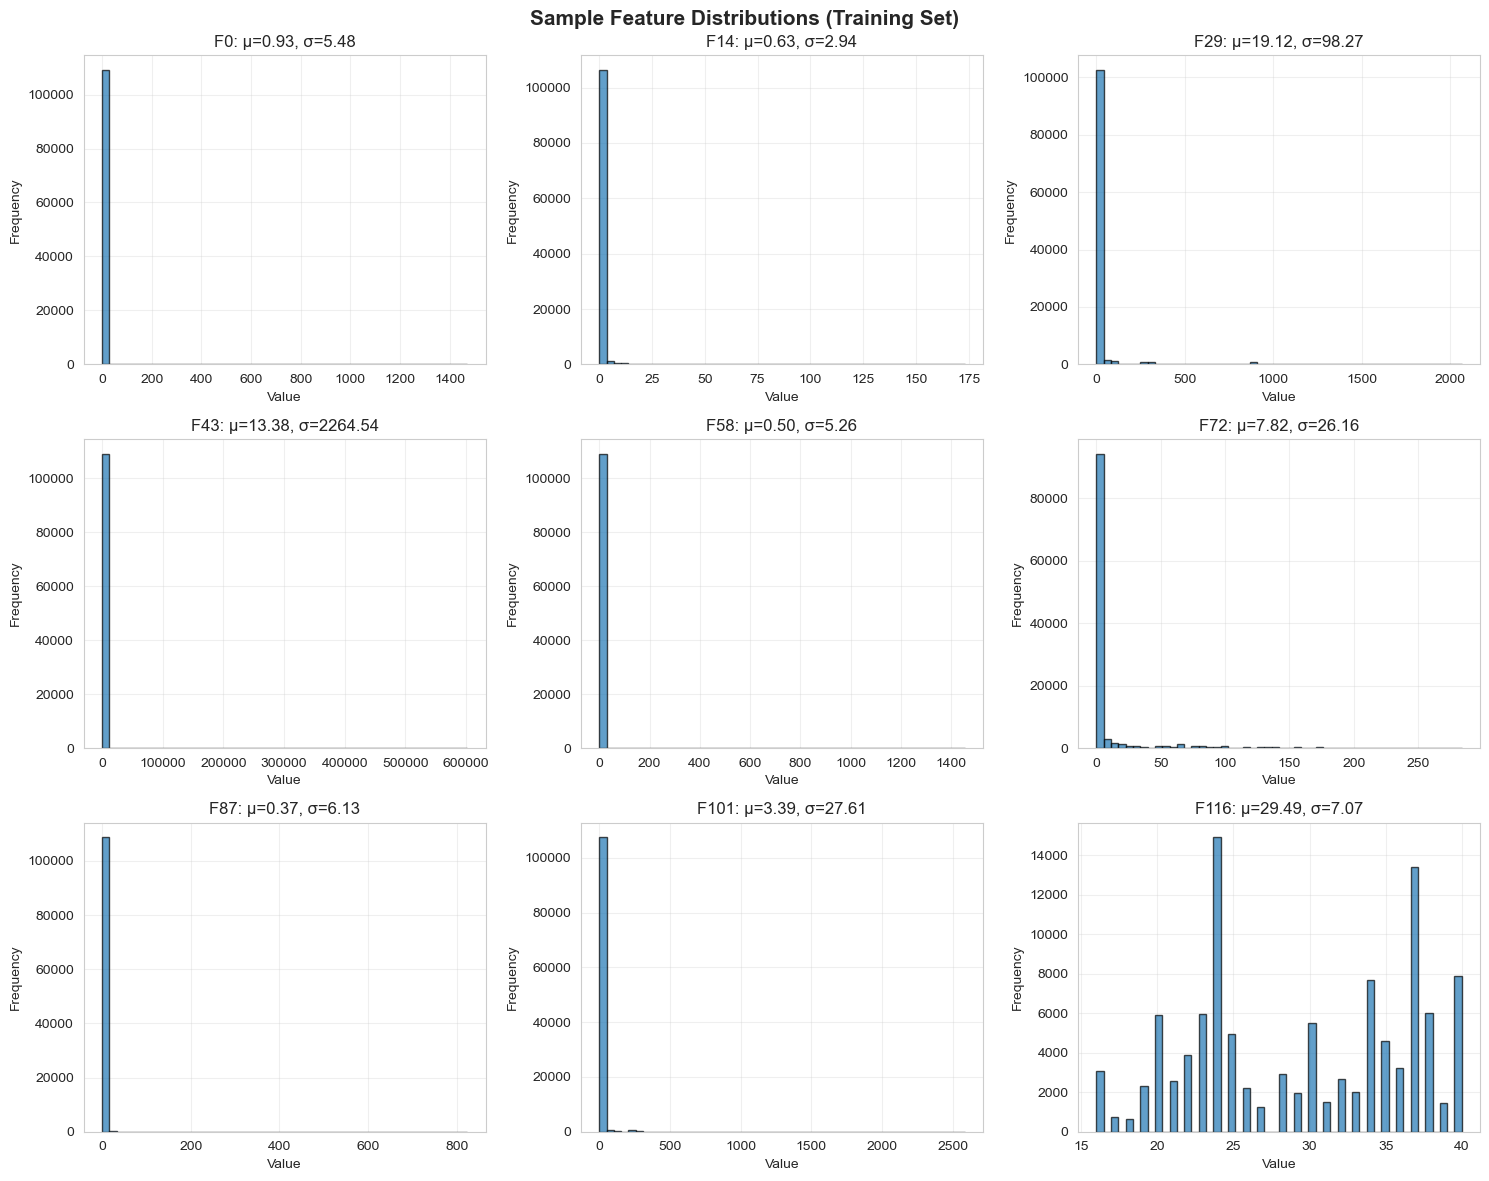

In [28]:
# Visualize feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Sample 9 features to visualize
sample_features = np.linspace(0, X_train.shape[1]-1, 9, dtype=int)

for idx, feat_idx in enumerate(sample_features):
    ax = axes[idx]
    
    # Plot histogram
    ax.hist(X_train[:, feat_idx], bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(f'{feature_names[feat_idx]}: μ={X_train[:, feat_idx].mean():.2f}, σ={X_train[:, feat_idx].std():.2f}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.suptitle('Sample Feature Distributions (Training Set)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Class Separation Analysis

**Key Question**: Can features distinguish between illicit and licit nodes?

In [29]:
print("="*70)
print("CLASS SEPARATION ANALYSIS")
print("="*70)

X_train_illicit = X_train[y_train == 1]
X_train_licit = X_train[y_train == 0]

print(f"\nIllicit nodes: {len(X_train_illicit):,}")
print(f"Licit nodes:   {len(X_train_licit):,}")
print(f"Ratio: 1:{len(X_train_licit)/len(X_train_illicit):.1f}")

# Kolmogorov-Smirnov test: measure if distributions differ
ks_scores = []
for i in range(X_train.shape[1]):
    stat, pval = ks_2samp(X_train_illicit[:, i], X_train_licit[:, i])
    ks_scores.append({'Feature': feature_names[i], 'KS_Statistic': stat, 'p_value': pval})

ks_df = pd.DataFrame(ks_scores)
ks_df['Significant'] = ks_df['p_value'] < 0.01  # Significant difference

print(f"\nFeatures with significant class separation (p < 0.01): {ks_df['Significant'].sum()} / {len(ks_df)}")

# Top 10 most discriminative features
print("\nTop 10 Most Discriminative Features:")
print(ks_df.nlargest(10, 'KS_Statistic')[['Feature', 'KS_Statistic', 'p_value']].to_string(index=False))

CLASS SEPARATION ANALYSIS

Illicit nodes: 7,237
Licit nodes:   101,896
Ratio: 1:14.1

Features with significant class separation (p < 0.01): 117 / 117

Top 10 Most Discriminative Features:
Feature  KS_Statistic  p_value
   F102      0.622220      0.0
   F103      0.622023      0.0
   F101      0.585205      0.0
    F96      0.560454      0.0
    F97      0.560263      0.0
    F93      0.556128      0.0
    F94      0.556116      0.0
    F44      0.535350      0.0
    F45      0.533549      0.0
    F92      0.532517      0.0


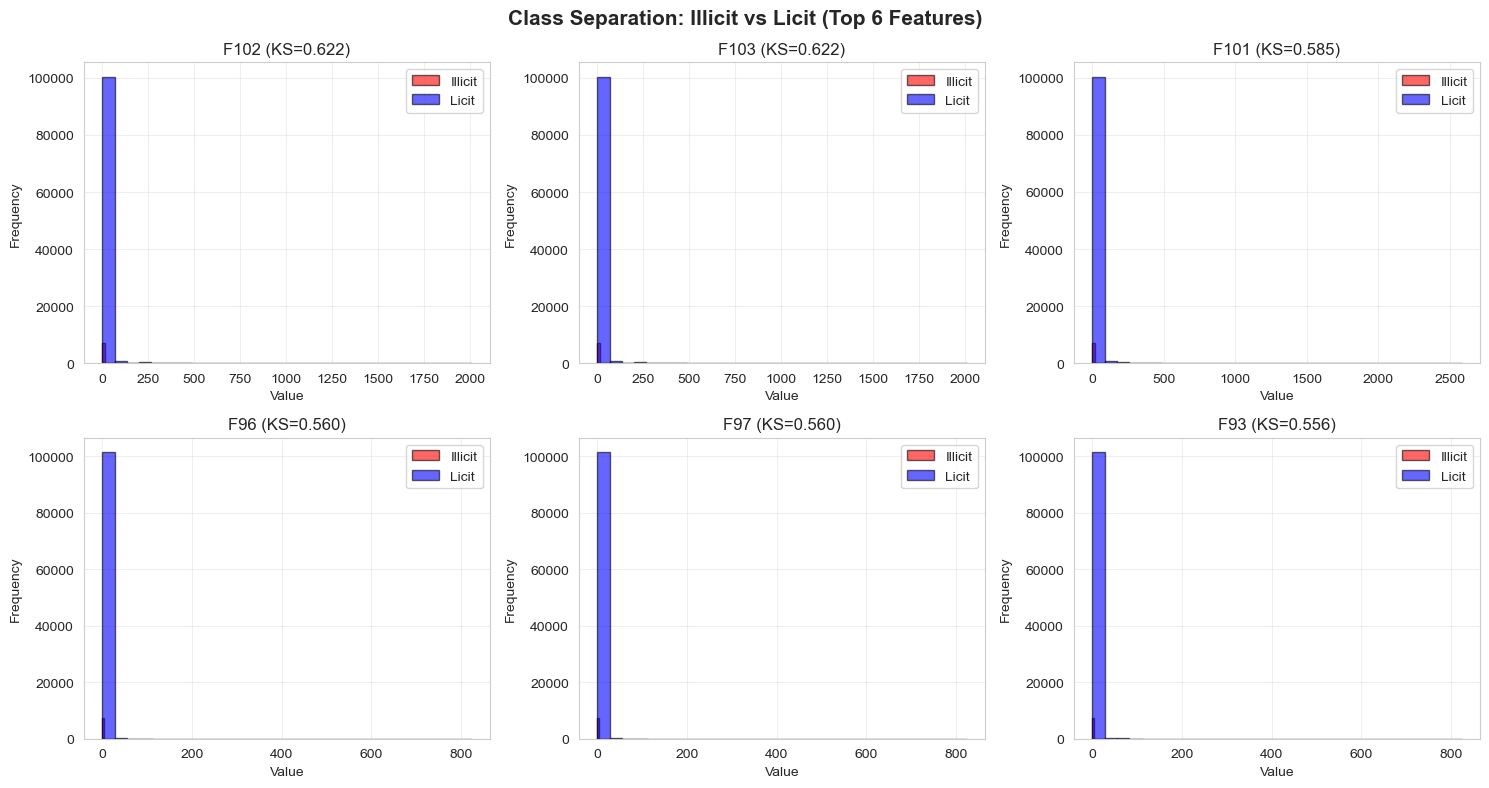

In [30]:
# Visualize class separation for top features
top_features = ks_df.nlargest(6, 'KS_Statistic')['Feature'].values
top_indices = [int(f[1:]) for f in top_features]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, feat_idx in enumerate(top_indices):
    ax = axes[idx]
    
    # Plot overlapping histograms
    ax.hist(X_train_illicit[:, feat_idx], bins=30, alpha=0.6, label='Illicit', color='red', edgecolor='black')
    ax.hist(X_train_licit[:, feat_idx], bins=30, alpha=0.6, label='Licit', color='blue', edgecolor='black')
    
    ks_stat = ks_df.iloc[feat_idx]['KS_Statistic']
    ax.set_title(f'{feature_names[feat_idx]} (KS={ks_stat:.3f})')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Class Separation: Illicit vs Licit (Top 6 Features)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Feature Importance (Random Forest)

Train a Random Forest to see which features are most predictive.

In [31]:
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
print("\nTraining Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=CONFIG['seed'],
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)

# Evaluate with comprehensive metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score

train_acc = rf.score(X_train_scaled, y_train)
test_acc = rf.score(X_test_scaled, y_test)

# Get predictions and probabilities
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

# Get probabilities - need to be careful about class ordering
# rf.classes_ shows the order: if [0, 1], then [:, 0] is prob(class=0)
print(f"\n  Model classes: {rf.classes_}")

# For AUC with pos_label=1 (illicit), we want P(y=1)
# predict_proba returns [P(class_0), P(class_1)]
# So if classes_ = [0, 1], we want [:, 1]
# But if classes_ = [1, 0], we'd want [:, 0]
class_1_idx = list(rf.classes_).index(1)  # Find which column has class 1
y_train_proba = rf.predict_proba(X_train_scaled)[:, class_1_idx]  # P(illicit)
y_test_proba = rf.predict_proba(X_test_scaled)[:, class_1_idx]

# Calculate F1 and AUC
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
    y_train, y_train_pred, average='binary', pos_label=1, zero_division=0
)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average='binary', pos_label=1, zero_division=0
)

try:
    train_auc = roc_auc_score(y_train, y_train_proba)
except Exception as e:
    print(f"  Warning: Could not compute train AUC: {e}")
    train_auc = 0.5

try:
    test_auc = roc_auc_score(y_test, y_test_proba)
except Exception as e:
    print(f"  Warning: Could not compute test AUC: {e}")
    test_auc = 0.5

print(f"\nTrain Performance:")
print(f"  Accuracy:  {train_acc:.4f}")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall:    {train_recall:.4f}")
print(f"  F1 Score:  {train_f1:.4f}")
print(f"  AUC:       {train_auc:.4f}")

print(f"\nTest Performance:")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1 Score:  {test_f1:.4f}")
print(f"  AUC:       {test_auc:.4f}")

# Confusion matrix to check if model is just predicting one class
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix (Test Set):")
print(f"                 Predicted")
print(f"               Licit  Illicit")
print(f"Actual Licit    {cm_test[0,0]:6d}  {cm_test[0,1]:6d}")
print(f"       Illicit  {cm_test[1,0]:6d}  {cm_test[1,1]:6d}")

# Prediction distribution
unique, counts = np.unique(y_test_pred, return_counts=True)
print(f"\nPrediction Distribution (Test Set):")
for label, count in zip(unique, counts):
    label_name = "Licit" if label == 0 else "Illicit"
    print(f"  {label_name}: {count:,} ({100*count/len(y_test_pred):.1f}%)")

# Check if it's predicting everything as one class
if len(unique) == 1:
    print(f"\n⚠️  WARNING: Model is predicting ONLY {['Licit', 'Illicit'][unique[0]]} class!")
    print(f"  This explains the poor performance.")
elif cm_test[1,1] == 0:
    print(f"\n⚠️  WARNING: Model NEVER predicts Illicit class correctly!")
    print(f"  Recall is 0, F1 will be very low.")

# Get feature importances
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))

# Check how many features have near-zero importance
low_importance = (importance_df['Importance'] < 0.001).sum()
print(f"\nFeatures with very low importance (<0.001): {low_importance} / {len(importance_df)}")

FEATURE IMPORTANCE ANALYSIS

Training Random Forest...

  Model classes: [0 1]

Train Performance:
  Accuracy:  0.9748
  Precision: 0.7270
  Recall:    0.9923
  F1 Score:  0.8392
  AUC:       0.9982

Test Performance:
  Accuracy:  0.9152
  Precision: 0.3281
  Recall:    0.3244
  F1 Score:  0.3262
  AUC:       0.8636

Confusion Matrix (Test Set):
                 Predicted
               Licit  Illicit
Actual Licit     45520    2138
       Illicit    2174    1044

Prediction Distribution (Test Set):
  Licit: 47,694 (93.7%)
  Illicit: 3,182 (6.3%)

Top 15 Most Important Features:
Feature  Importance
   F102    0.061468
   F103    0.051333
    F44    0.033168
    F12    0.029247
    F93    0.028868
    F92    0.026027
    F11    0.025099
    F96    0.024781
    F94    0.024217
    F45    0.022989
    F23    0.022836
    F62    0.021265
    F24    0.020705
    F54    0.019577
   F101    0.018444

Features with very low importance (<0.001): 6 / 117


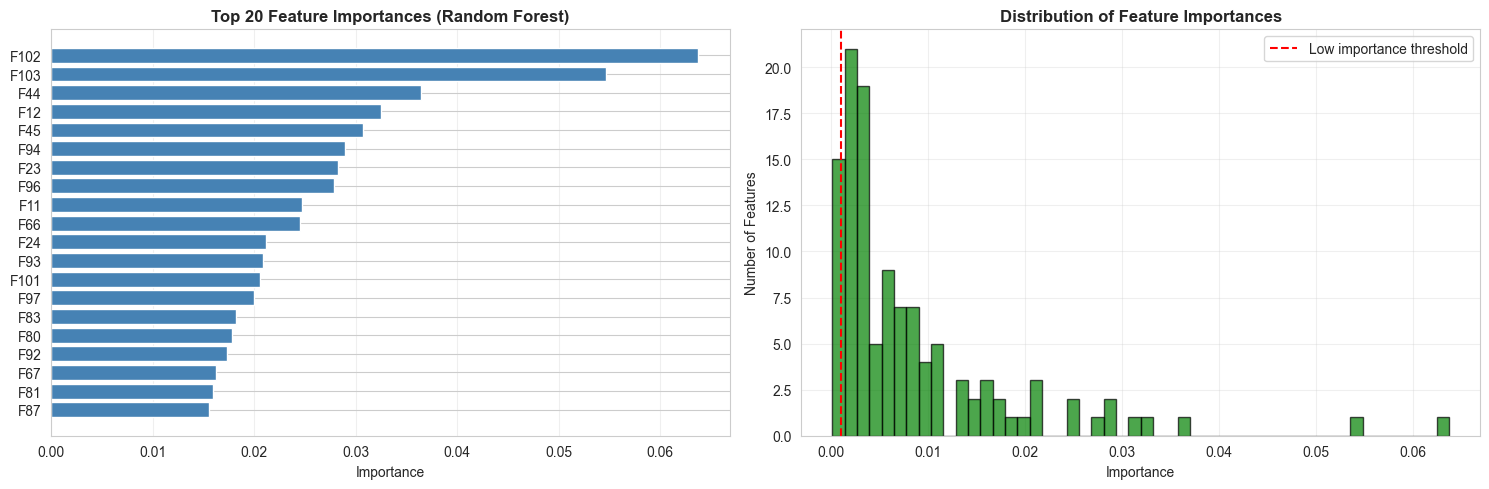

In [14]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Top 20 features
ax = axes[0]
top20 = importance_df.head(20)
ax.barh(range(len(top20)), top20['Importance'].values, color='steelblue')
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(top20['Feature'].values)
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importances (Random Forest)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# Distribution of importances
ax = axes[1]
ax.hist(importance_df['Importance'].values, bins=50, edgecolor='black', color='green', alpha=0.7)
ax.set_xlabel('Importance')
ax.set_ylabel('Number of Features')
ax.set_title('Distribution of Feature Importances', fontweight='bold')
ax.axvline(0.001, color='red', linestyle='--', label='Low importance threshold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Dimensionality Reduction & Visualization

Can we visualize class separation in low dimensions?

In [32]:
# Sample data for visualization (too many points to plot)
sample_size = 5000
sample_indices = np.random.choice(len(X_train), size=min(sample_size, len(X_train)), replace=False)
X_sample = X_train_scaled[sample_indices]
y_sample = y_train[sample_indices]

print(f"Sampling {len(X_sample):,} points for visualization...")
print(f"  Illicit: {np.sum(y_sample==1)}")
print(f"  Licit:   {np.sum(y_sample==0)}")

Sampling 5,000 points for visualization...
  Illicit: 333
  Licit:   4667


In [33]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

print(f"PCA explained variance: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

PCA explained variance: [0.26189005 0.21420476]
Total variance explained: 47.61%


In [34]:
# t-SNE (slower, but better for visualization)
print("\nComputing t-SNE (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=CONFIG['seed'], perplexity=30)
X_tsne = tsne.fit_transform(X_sample)
print("Done!")


Computing t-SNE (this may take a minute)...
Done!


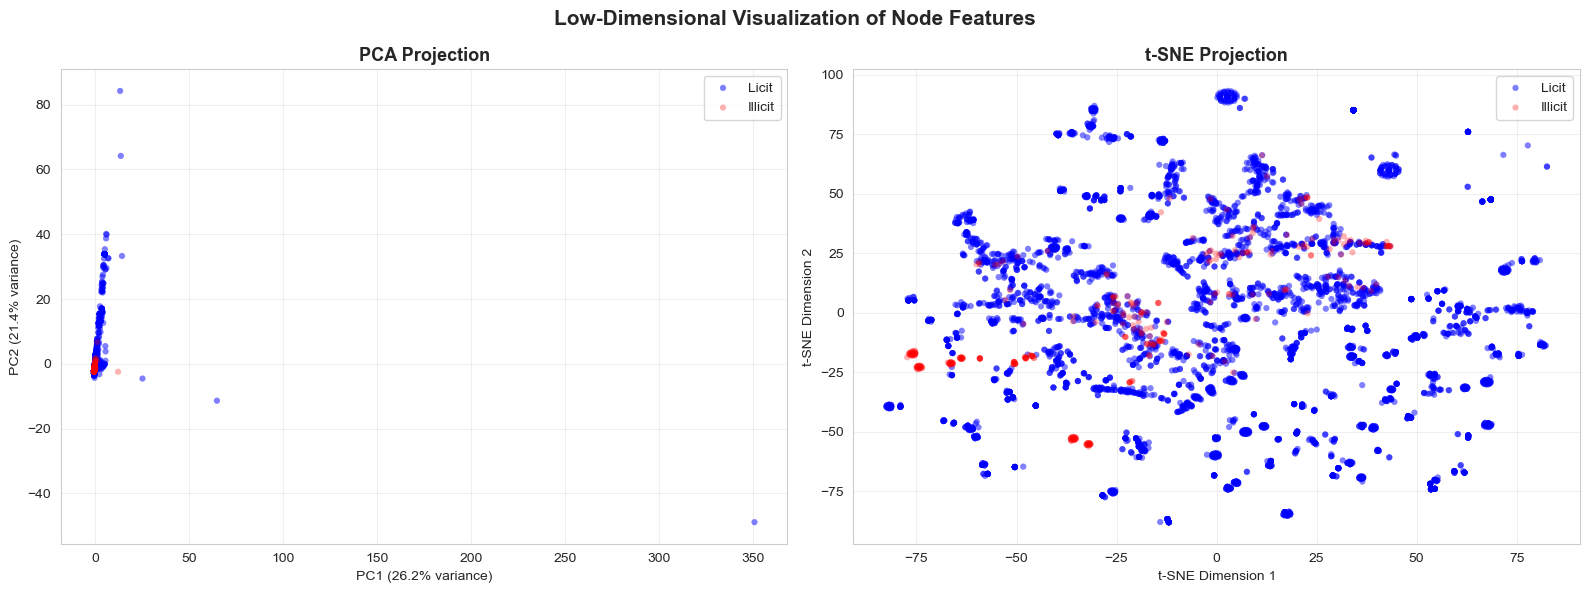

In [44]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA
ax = axes[0]
scatter_pca = ax.scatter(X_pca[y_sample==0, 0], X_pca[y_sample==0, 1], 
                          c='blue', alpha=0.5, s=20, label='Licit', edgecolors='none')
scatter_pca = ax.scatter(X_pca[y_sample==1, 0], X_pca[y_sample==1, 1], 
                          c='red', alpha=0.3, s=20, label='Illicit', edgecolors='none')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('PCA Projection', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

# t-SNE
ax = axes[1]
scatter_tsne = ax.scatter(X_tsne[y_sample==0, 0], X_tsne[y_sample==0, 1], 
                           c='blue', alpha=0.5, s=20, label='Licit', edgecolors='none')
scatter_tsne = ax.scatter(X_tsne[y_sample==1, 0], X_tsne[y_sample==1, 1], 
                           c='red', alpha=0.3, s=20, label='Illicit', edgecolors='none')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_title('t-SNE Projection', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Low-Dimensional Visualization of Node Features', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Feature Correlation Analysis

Are features redundant?

In [36]:
# Compute correlation matrix (subsample for speed)
print("Computing feature correlations...")
sample_for_corr = min(10000, len(X_train))
corr_matrix = np.corrcoef(X_train[:sample_for_corr].T)

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if abs(corr_matrix[i, j]) > 0.9:
            high_corr_pairs.append((feature_names[i], feature_names[j], corr_matrix[i, j]))

print(f"\nHighly correlated feature pairs (|r| > 0.9): {len(high_corr_pairs)}")
if high_corr_pairs:
    print("\nTop 10 most correlated pairs:")
    for pair in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        print(f"  {pair[0]} <-> {pair[1]}: r={pair[2]:.3f}")

Computing feature correlations...

Highly correlated feature pairs (|r| > 0.9): 449

Top 10 most correlated pairs:
  F2 <-> F8: r=1.000
  F4 <-> F25: r=1.000
  F4 <-> F55: r=1.000
  F5 <-> F26: r=1.000
  F5 <-> F56: r=1.000
  F25 <-> F55: r=1.000
  F26 <-> F56: r=1.000
  F59 <-> F65: r=1.000
  F61 <-> F67: r=1.000
  F62 <-> F98: r=1.000


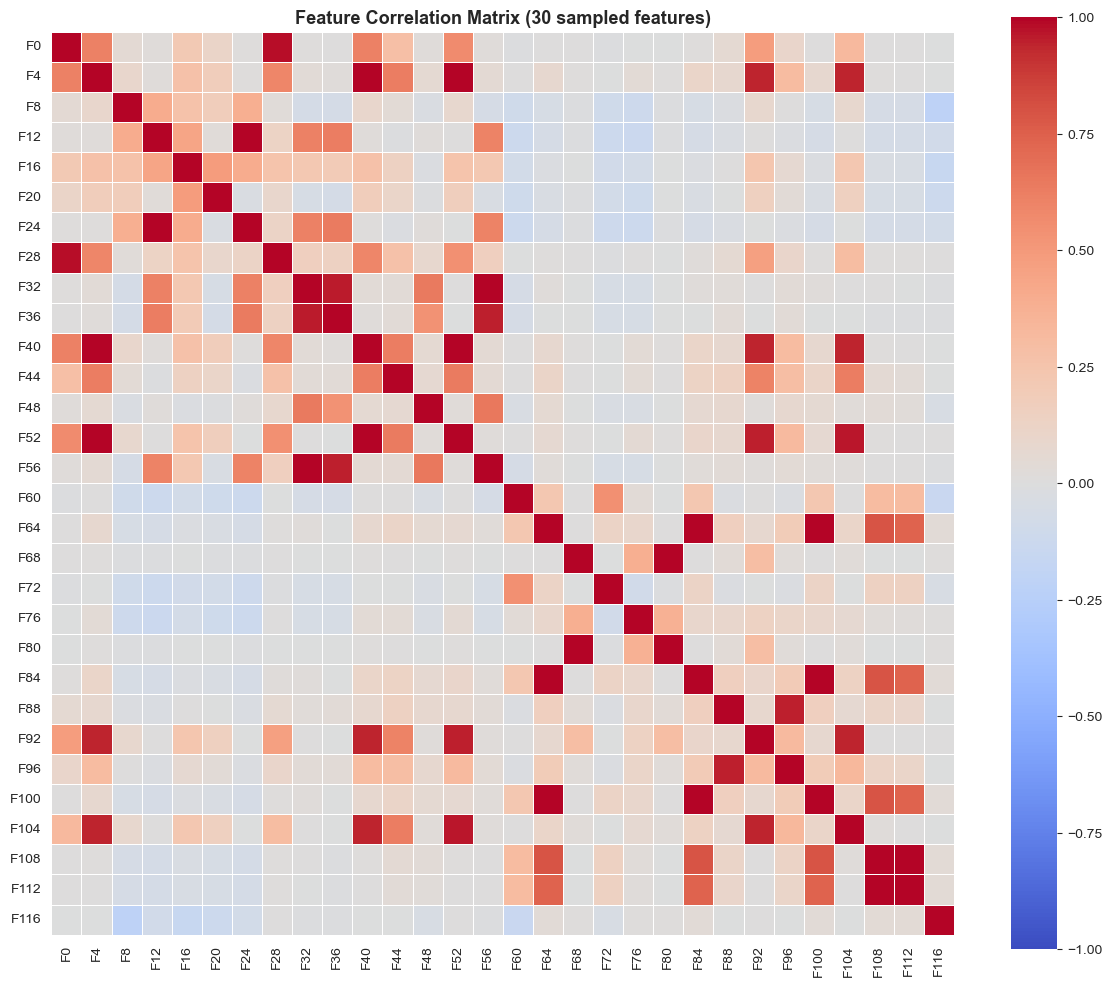

In [37]:
# Visualize correlation matrix (subsample features for readability)
sample_features_for_viz = np.linspace(0, X_train.shape[1]-1, 30, dtype=int)
corr_subset = corr_matrix[sample_features_for_viz][:, sample_features_for_viz]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_subset, 
            xticklabels=[feature_names[i] for i in sample_features_for_viz],
            yticklabels=[feature_names[i] for i in sample_features_for_viz],
            cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix (30 sampled features)', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

## 8. Summary & Diagnosis

In [38]:
print("="*70)
print("FEATURE ANALYSIS SUMMARY")
print("="*70)

print("\n1. FEATURE QUALITY:")
print(f"   ✓ Total features: {X_train.shape[1]}")
print(f"   ⚠ Near-zero variance: {stats['Near_Zero_Var'].sum()}")
print(f"   ⚠ Mostly zero (>90%): {stats['Mostly_Zero'].sum()}")
print(f"   ⚠ Low importance (<0.001): {low_importance}")

print("\n2. CLASS SEPARATION:")
print(f"   ✓ Significant features (p<0.01): {ks_df['Significant'].sum()} / {len(ks_df)}")
print(f"   ✓ Random Forest test accuracy: {test_acc:.4f}")
print(f"   ✓ Random Forest test F1 score: {test_f1:.4f}")
print(f"   ✓ Random Forest test AUC: {test_auc:.4f}")
if test_f1 > 0.6:
    print(f"   → Features ARE predictive (RF achieves good performance)")
elif test_f1 > 0.3:
    print(f"   → Features have SOME signal but not strong")
else:
    print(f"   → Features have MINIMAL predictive power")

print("\n3. FEATURE REDUNDANCY:")
print(f"   ⚠ Highly correlated pairs: {len(high_corr_pairs)}")
if len(high_corr_pairs) > 50:
    print(f"   → Many redundant features, dimensionality reduction may help")

print("\n4. VISUALIZATION:")
print(f"   PCA variance (2 components): {pca.explained_variance_ratio_.sum():.2%}")
if pca.explained_variance_ratio_.sum() < 0.3:
    print(f"   → Features are high-dimensional, linear methods may struggle")

print("\n" + "="*70)
print("DIAGNOSIS")
print("="*70)

# Diagnose the problem
issues = []
recommendations = []

if stats['Near_Zero_Var'].sum() > X_train.shape[1] * 0.3:
    issues.append("⚠️  >30% of features have near-zero variance")
    recommendations.append("→ Remove low-variance features")

if ks_df['Significant'].sum() < len(ks_df) * 0.1:
    issues.append("⚠️  <10% of features show significant class separation")
    recommendations.append("→ Feature engineering needed, current features weak")

if test_f1 < 0.3:
    issues.append(f"⚠️  Random Forest only achieves {test_f1:.2%} F1 score (Acc: {test_acc:.2%})")
    recommendations.append("→ Features lack predictive power OR extreme class imbalance")

if len(high_corr_pairs) > 100:
    issues.append(f"⚠️  {len(high_corr_pairs)} highly correlated feature pairs")
    recommendations.append("→ Apply PCA or feature selection to reduce redundancy")

if pca.explained_variance_ratio_.sum() < 0.2:
    issues.append("⚠️  First 2 PCA components explain <20% variance")
    recommendations.append("→ Data is very high-dimensional, may need more complex models")

print("\nISSUES IDENTIFIED:")
if issues:
    for issue in issues:
        print(f"  {issue}")
else:
    print("  ✅ No major feature quality issues detected")

print("\nRECOMMENDATIONS:")
if recommendations:
    for rec in recommendations:
        print(f"  {rec}")
else:
    print("  ✅ Features appear usable")
    
# Key insight
print("\n" + "="*70)
print(f"Random Forest Baseline: F1={test_f1:.4f}, AUC={test_auc:.4f}, Acc={test_acc:.4f}")
print("="*70)
if test_f1 > 0.6:
    print("✅ FEATURES ARE GOOD: Random Forest works well!")
    print("   Problem is likely with GCN/LR implementation:")
    print("   - Class imbalance not properly handled")
    print("   - Need Focal Loss or better class weighting")
    print("   - Need feature normalization for GCN")
    print("\n   Compare this RF F1 to your GCN/LR F1:")
    print(f"   RF F1: {test_f1:.4f} vs GCN/LR F1: ~0.07-0.08")
    print("   → Your models are underperforming by ~10x!")
elif test_f1 > 0.3:
    print("⚠️  FEATURES HAVE SOME SIGNAL: RF achieves modest performance")
    print("   Improvements needed:")
    print("   - Better handling of class imbalance")
    print("   - Feature engineering (create domain-specific features)")
    print("   - Feature selection (remove uninformative features)")
    print("\n   Compare this RF F1 to your GCN/LR F1:")
    print(f"   RF F1: {test_f1:.4f} vs GCN/LR F1: ~0.07-0.08")
    if test_f1 > 0.15:
        print("   → Your models are still underperforming, but features are weak too")
else:
    print("❌ FEATURES ARE WEAK: Even RF struggles")
    print("   Major problems:")
    print("   - Features don't capture fraud patterns well")
    print("   - Need domain knowledge to engineer better features")
    print("   - Graph structure may be critical (if it exists)")
    print(f"\n   RF F1: {test_f1:.4f} is similar to GCN/LR F1: ~0.07-0.08")
    print("   → The problem is fundamentally the features, not the models")
    
print("="*70)

FEATURE ANALYSIS SUMMARY

1. FEATURE QUALITY:
   ✓ Total features: 117
   ⚠ Near-zero variance: 0
   ⚠ Mostly zero (>90%): 0
   ⚠ Low importance (<0.001): 6

2. CLASS SEPARATION:
   ✓ Significant features (p<0.01): 117 / 117
   ✓ Random Forest test accuracy: 0.9152
   ✓ Random Forest test F1 score: 0.3262
   ✓ Random Forest test AUC: 0.8636
   → Features have SOME signal but not strong

3. FEATURE REDUNDANCY:
   ⚠ Highly correlated pairs: 449
   → Many redundant features, dimensionality reduction may help

4. VISUALIZATION:
   PCA variance (2 components): 47.61%

DIAGNOSIS

ISSUES IDENTIFIED:
  ⚠️  449 highly correlated feature pairs

RECOMMENDATIONS:
  → Apply PCA or feature selection to reduce redundancy

Random Forest Baseline: F1=0.3262, AUC=0.8636, Acc=0.9152
⚠️  FEATURES HAVE SOME SIGNAL: RF achieves modest performance
   Improvements needed:
   - Better handling of class imbalance
   - Feature engineering (create domain-specific features)
   - Feature selection (remove uninforma